# Multimodal Retrieval Augmented Generation (RAG)

##### Note: This example requires KDB.AI server. Sign up for a free [KDB.AI account](https://kdb.ai/get-started).

This example explores preparing, embedding, and storing both text and image data within a KDB.AI vector database. Our goal is to store both images descriptions and text within the same vector space so we can search over both modalities at the same time. KDB.AI can then be used as a retrieval tool within a RAG pipeline for both text and images data, making it a multimodal retriever. 

The dataset we are working with contains images of several different animals, and text descriptions of those animals. After implementation, a user should be able to write a query regarding any of these animals and get returned both images and text related to the animal of interest.

The method in this notebook uses a multimodal LLM to describe images within our dataset. Since the images will be described in text, the descriptions can be treated similary to our raw text data. Therefore all data can be embedded by the same model, and stored in the same vector space!

### Agenda:
0. Setup
1. Helper Functions
2. Data Import
3. Embed Texts and Images
4. Set Up KDB.AI Vector Database table
5. Insert data into KDB.AI Vector Database
6. Query vector database to retrieve most relevant data
7. Retrieval Augmented Generation
8. Drop the table

Animal Images Source: https://www.kaggle.com/datasets/iamsouravbanerjee/animal-image-dataset-90-different-animals

## 0. Setup
Dependencies, Imports, and API Keys

In order to successfully run this sample, note the following steps depending on where you are running this notebook:

-***Run Locally / Private Environment:*** The [Setup](https://github.com/KxSystems/kdbai-samples/blob/main/README.md#setup) steps in the repository's `README.md` will guide you on prerequisites and how to run this with Jupyter.


-***Colab / Hosted Environment:*** Open this notebook in Colab and run through the cells.

In [ ]:
!pip install kdbai_client langchain openai langchain-community

In [21]:
import pandas as pd
import os
import io
from getpass import getpass
import langchain
import openai
from openai import OpenAI
import numpy as np
from PIL import Image
from langchain.chat_models import ChatOpenAI
from langchain.schema.messages import HumanMessage, SystemMessage
from IPython.display import display
import time
import warnings
import requests
warnings.filterwarnings('ignore')

In [22]:
### !!! Only run this cell if you need to download the data into your environment, for example in Colab
### This downloads image and text data

!mkdir -p ./data/images
!mkdir -p ./data/text

def get_github_repo_contents(repo_owner, repo_name, branch, folder_path):
    # Construct the API URL
    api_url = f"https://api.github.com/repos/{repo_owner}/{repo_name}/contents/{folder_path}?ref={branch}"
    
    # Send the request and process the response
    contents = requests.get(api_url).json()

    # Create the local directory if it doesn't exist
    fPath = f"./data/{folder_path.split('/')[-1]}"

    for item in contents:
        # Recursively list contents of subfolder
        if item['type'] == 'dir':
            get_github_repo_contents(repo_owner, repo_name, branch, f"{folder_path}/{item['name']}")
        # Download and save file
        elif item['type'] == 'file':
            file_url = f"https://raw.githubusercontent.com/{repo_owner}/{repo_name}/{branch}/{folder_path}/{item['name']}"
            print(file_url)
            r = requests.get(file_url, timeout=4.0)
            r.raise_for_status()  # Raises an exception for HTTP errors
            file_path = f"{fPath}/{item['name']}"

            if item['name'].lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                # Save image file
                with Image.open(io.BytesIO(r.content)) as im:
                    im.save(file_path)
            else:
                # Save text file
                with open(file_path, 'wb') as f:
                    f.write(r.content)

# Get images and texts
get_github_repo_contents(
    repo_owner='KxSystems',
    repo_name='kdbai-samples',
    branch='main',
    folder_path='multimodal_RAG_unified_text/data'
)

https://raw.githubusercontent.com/KxSystems/kdbai-samples/main/multimodal_RAG_unified_text/data/images/bat1.jpg
https://raw.githubusercontent.com/KxSystems/kdbai-samples/main/multimodal_RAG_unified_text/data/images/bat2.jpg
https://raw.githubusercontent.com/KxSystems/kdbai-samples/main/multimodal_RAG_unified_text/data/images/bear1.jpg
https://raw.githubusercontent.com/KxSystems/kdbai-samples/main/multimodal_RAG_unified_text/data/images/bear2.jpg
https://raw.githubusercontent.com/KxSystems/kdbai-samples/main/multimodal_RAG_unified_text/data/images/caterpillar1.jpg
https://raw.githubusercontent.com/KxSystems/kdbai-samples/main/multimodal_RAG_unified_text/data/images/caterpillar2.jpg
https://raw.githubusercontent.com/KxSystems/kdbai-samples/main/multimodal_RAG_unified_text/data/images/deer1.jpg
https://raw.githubusercontent.com/KxSystems/kdbai-samples/main/multimodal_RAG_unified_text/data/images/deer2.jpg
https://raw.githubusercontent.com/KxSystems/kdbai-samples/main/multimodal_RAG_unifie

In [23]:
os.environ["OPENAI_API_KEY"] = (
    os.environ["OPENAI_API_KEY"]
    if "OPENAI_API_KEY" in os.environ
    else getpass("OpenAI API Key: ")
)

In [24]:
openai.api_key = os.environ["OPENAI_API_KEY"]
client = OpenAI()

## 1. Helper functions
1. encode_image: this function takes in an image file's path, and converts the image to base64 encoding which can be used by OpenAI's LLM "gpt-4-vision-preview"
2. image_summarize: takes in a base64 encoded image and a prompt, returns a text description of the image
3. read_text_from_file: takes in a file path, returns the text within that file
4. text_to_embedding: takes in text, outputs a vector embedding of that text that can be stored in a vector database

In [25]:
import base64

# Helper function to convert a file to base64 representation
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

# Takes in a base64 encoded image and a prompt, returns a text description of the image
def image_summarize(img_base64,prompt):
    ''' Image summary '''
    for _ in range(3):
        response = openai.chat.completions.create(
            model="gpt-4o",
            messages=[
                {
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt},
                    {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{img_base64}",
                    },
                    },
                ],
                }
            ],
            max_tokens=150,
        )
        content = response.choices[0].message.content

        if "I'm sorry" not in content:
            return content
        time.sleep(3)
    return content

#Return the text from a file
def read_text_from_file(filename):
    try:
        # Open the file in read mode ('r')
        with open(filename, 'r') as file:
            # Read the contents of the file into a string
            text = file.read()
        return text
    except IOError as e:
        # Handle any I/O errors
        print(f"An error occurred: {e}")
        return None

#model="text-embedding-3-small"
#Takes in text and returns a vector embedding using text-embedding-3-small
def text_to_embedding(text):
    text = text.replace("\n", " ")
    return client.embeddings.create(input = [text], model="text-embedding-3-small").data[0].embedding
   

## 2. Data Import
Get the filepaths for all text and image files


In [26]:
images = os.listdir("./data/images")
texts = os.listdir("./data/text")

In [27]:
# Prepare a dataframe to store file path, media_type, text, and embeddings in
columns = ['path','media_type','text','embeddings']
df = pd.DataFrame(columns=columns)

## 3. Embed Texts and Images
Loop through all text files and embed them, store relevant data in dataframe.
Loop through all image files, get image summaries, embed the summaries, store relevant data in dataframe.

In [28]:
#Loop through all text files and embed them, store relevant data in dataframe
for text in texts:
    path = "./data/text/" + text
    media_type = "text"
    text1 = read_text_from_file(path)
    embedding = text_to_embedding(text1)
    new_row = {'path': path,
               'media_type':'text',
               'text' : text1,
               'embeddings': embedding}
    df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

In [29]:
# Let's take a look at the dataframe so far
df.head()

,path,media_type,text,embeddings
0,./data/text/bat.txt,text,Bats are the only mammals capable of sustained...,"[0.043051157146692276, 0.05017940700054169, 0...."
1,./data/text/bear.txt,text,"Bears are large mammals with a stocky body, po...","[0.052125297486782074, 0.0072755659930408, 0.0..."
2,./data/text/deer.txt,text,Deer are hoofed mammals known for their gracef...,"[0.07531881332397461, 0.03122134692966938, 0.0..."
3,./data/text/caterpillar.txt,text,Caterpillars are the larval stage of butterfli...,"[0.05927688628435135, -0.017723916098475456, 0..."
4,./data/text/hedgehog.txt,text,"Hedgehogs are small, nocturnal mammals known f...","[0.0144752012565732, 0.0004009466210845858, 0...."


In [30]:
#Loop through all image files, get image summaries, embed the summaries, store relevant data in dataframe. Takes a couple of minutes
for image in images:
    path = "./data/images/" + image
    media_type = "images"
    base64_image = encode_image(path)
    prompt = "Describe the image in detail."
    summarization = image_summarize(base64_image,prompt)
    embedding = text_to_embedding(summarization)
    new_row = {'path': path,
               'media_type':'image',
               'text' : summarization,
               'embeddings': embedding}
    df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

In [31]:
# Print the entire dataframe
df

,path,media_type,text,embeddings
0,./data/text/bat.txt,text,Bats are the only mammals capable of sustained...,"[0.043051157146692276, 0.05017940700054169, 0...."
1,./data/text/bear.txt,text,"Bears are large mammals with a stocky body, po...","[0.052125297486782074, 0.0072755659930408, 0.0..."
2,./data/text/deer.txt,text,Deer are hoofed mammals known for their gracef...,"[0.07531881332397461, 0.03122134692966938, 0.0..."
3,./data/text/caterpillar.txt,text,Caterpillars are the larval stage of butterfli...,"[0.05927688628435135, -0.017723916098475456, 0..."
4,./data/text/hedgehog.txt,text,"Hedgehogs are small, nocturnal mammals known f...","[0.0144752012565732, 0.0004009466210845858, 0...."
5,./data/text/fox.txt,text,"Foxes are small to medium-sized, omnivorous ma...","[0.017004722729325294, 0.017473476007580757, 0..."
6,./data/images/fox2.jpg,image,The image features a red fox standing in front...,"[-0.0029516557697206736, -0.010554404929280281..."
7,./data/images/bat2.jpg,image,The image shows a large bat hanging upside dow...,"[0.059701841324567795, -0.008926010690629482, ..."
8,./data/images/bat1.jpg,image,The image depicts a bat in flight at night. Th...,"[0.015258435159921646, 0.015619066543877125, 0..."
9,./data/images/deer2.jpg,image,"The image depicts a mature male deer, known as...","[0.0621773786842823, -0.013964351266622543, -0..."


## 4. Set Up KDB.AI Vector Database table
Time to get KDB.AI vector database set up. If you do not have an account, go to KDB.AI to sign-up free!

To use KDB.AI Server, you will need download and run your own container.
To do this, you will first need to sign up for free [here](https://trykdb.kx.com/kdbaiserver/signup/).

You will receive an email with the required license file and bearer token needed to download your instance.
Follow instructions in the signup email to get your session up and running.

Once the [setup steps](https://code.kx.com/kdbai/gettingStarted/kdb-ai-server-setup.html) are complete you can then connect to your KDB.AI Server session using `kdbai.Session` and passing your local endpoint.


In [32]:
# vector DB imports
import os
from getpass import getpass
import kdbai_client as kdbai
import time

In [ ]:
#Set up KDB.AI server endpoint 
KDBAI_ENDPOINT = (
    os.environ["KDBAI_ENDPOINT"]
    if "KDBAI_ENDPOINT" in os.environ
    else "http://localhost:8082"
)

#connect to KDB.AI Server, default mode is qipc
session = kdbai.Session(endpoint=KDBAI_ENDPOINT)

In [35]:
# Define table schema for our table with columns for path, media_type, text, and embeddings
table_schema = [
    {"name": "path", "type": "str"},
    {"name": "media_type", "type": "str"},
    {"name": "text", "type": "str"},
    {"name": "embeddings", "type": "float64s"}
]
index_name = "flat_index"
indexes = [{"name": index_name, "column": "embeddings", "type": "flat", "params": {"dims": 1536, "metric": "CS"}}]

In [36]:
database = session.database("default")
# First ensure the table does not already exist
try:
    database.table("multi_modal_demo").drop()
except kdbai.KDBAIException:
    pass

In [37]:
# Create the table called "multi_modal_demo"
table = database.create_table("multi_modal_demo", schema=table_schema, indexes=indexes)

## 5. Insert data into KDB.AI Vector Database

In [38]:
#Insert the data into the table, split into 2000 row batches
from tqdm import tqdm 
n = 2000  # chunk row size

for i in tqdm(range(0, df.shape[0], n)):
    table.insert(df[i:i+n].reset_index(drop=True))

100%|██████████| 1/1 [00:00<00:00, 15.52it/s]


In [39]:
# See what is in our table - confirm the data was inserted
table.query()

,path,media_type,text,embeddings
0,./data/text/bat.txt,text,Bats are the only mammals capable of sustained...,"[0.043051157146692276, 0.05017940700054169, 0...."
1,./data/text/bear.txt,text,"Bears are large mammals with a stocky body, po...","[0.052125297486782074, 0.0072755659930408, 0.0..."
2,./data/text/deer.txt,text,Deer are hoofed mammals known for their gracef...,"[0.07531881332397461, 0.03122134692966938, 0.0..."
3,./data/text/caterpillar.txt,text,Caterpillars are the larval stage of butterfli...,"[0.05927688628435135, -0.017723916098475456, 0..."
4,./data/text/hedgehog.txt,text,"Hedgehogs are small, nocturnal mammals known f...","[0.0144752012565732, 0.0004009466210845858, 0...."
5,./data/text/fox.txt,text,"Foxes are small to medium-sized, omnivorous ma...","[0.017004722729325294, 0.017473476007580757, 0..."
6,./data/images/fox2.jpg,image,The image features a red fox standing in front...,"[-0.0029516557697206736, -0.010554404929280281..."
7,./data/images/bat2.jpg,image,The image shows a large bat hanging upside dow...,"[0.059701841324567795, -0.008926010690629482, ..."
8,./data/images/bat1.jpg,image,The image depicts a bat in flight at night. Th...,"[0.015258435159921646, 0.015619066543877125, 0..."
9,./data/images/deer2.jpg,image,"The image depicts a mature male deer, known as...","[0.0621773786842823, -0.013964351266622543, -0..."


## 6. Query vector database to retrieve most relevant data 
Our vector database now contains embeddings representing both text files and images! We can query the vector database to find the most relevant animal based on our query. 

Retrieved results can then be sent to an LLM for RAG

In [40]:
query_vector = [text_to_embedding("what is the purpose of having antlers?")]

In [41]:
results = table.search({index_name: query_vector}, n=3)
print(results)

[   __nn_distance                     path media_type  \
0       0.438880     ./data/text/deer.txt       text   
1       0.417827  ./data/images/deer1.jpg      image   
2       0.410783  ./data/images/deer2.jpg      image   

                                                text  \
0  Deer are hoofed mammals known for their gracef...   
1  The image shows a male deer, commonly referred...   
2  The image depicts a mature male deer, known as...   

                                          embeddings  
0  [0.07531881332397461, 0.03122134692966938, 0.0...  
1  [0.06323786079883575, -0.020763417705893517, -...  
2  [0.0621773786842823, -0.013964351266622543, -0...  ]


#### View the data that was retrieved:

Deer are hoofed mammals known for their graceful bodies and long legs. Most male deer have antlers, which they shed and regrow annually. They are herbivores, generally feeding on a mix of grasses, plants, and leaves. Deer are found in various habitats across the world, including forests, grasslands, and wetlands.


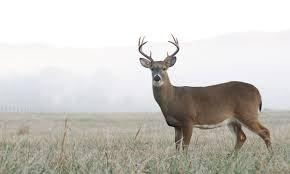

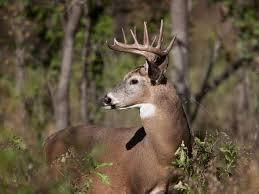

In [42]:
retrieved_data_for_RAG = []
for index, row in results[0].iterrows():
    if row[2] == 'image':
        retrieved_data_for_RAG.append(row[3])
        image = Image.open(row[1])
        display(image)
    elif row[2] == 'text':
        retrieved_data_for_RAG.append(row[3])
        print(row[3])

## 7. RAG Time!
Finally, we can pass our retrieved data and prompt into an LLM -  this is the generation step in RAG.

In [43]:
# Helper function to execute RAG, we pass in a list of retrieved data, and the prompt
# The function returns the LLM's response

def RAG(retrieved_data,prompt):
    messages = ""
    messages += prompt + "\n"
    if retrieved_data:
        for data in retrieved_data:
            messages += data + "\n"
    response = openai.chat.completions.create(
        model="gpt-4o",
        messages=[           
            {
            "role": "user",
            "content": [
                {"type": "text", "text": messages},
            ],
            }
        ],
        max_tokens=300, 
    )
    content = response.choices[0].message.content
    return content


In [44]:
prompt = "what is the purpose of having antlers?"
query = "You will answer the given prompt using attached content: "+prompt
response = RAG(retrieved_data_for_RAG, query)
print(response)

The purpose of having antlers in deer, particularly for male deer or bucks, primarily revolves around attracting mates and establishing dominance. Antlers are used in a variety of ways including:

1. **Mate Attraction**: Antlers play a significant role during the mating season, also known as the rut. Large, well-developed antlers are often considered a sign of a healthy and genetically superior individual, making bucks with impressive antlers more attractive to females.

2. **Fighting and Dominance**: Bucks use their antlers to fight with other males to establish dominance and gain access to females. These fights can involve pushing and locking antlers to display strength and resolve. The multiple points on the antlers can be an indicator of the deer's maturity and experience.

3. **Defense**: Although not as common, antlers can also be used as a means of defense against predators.

The image of the mature male deer, or buck, with its large, multi-pointed antlers standing alert in an o

## 8. Delete the KDB.AI Table

Once finished with the table, it is best practice to drop it.

In [45]:
table.drop()

#### Take Our Survey
We hope you found this sample helpful! Your feedback is important to us, and we would appreciate it if you could take a moment to fill out our brief survey. Your input helps us improve our content.

Take the [Survey](https://delighted.com/t/dfAHRG9R)
